In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

In [2]:
%config IPCompleter.greedy=True

In [3]:
df = pd.read_csv('data/mitbih_train.csv', header=None)
df2 = pd.read_csv('data/mitbih_test.csv', header=None)
df = pd.concat([df, df2], axis=0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


In [4]:
M = df.values
X = M[:,:-1]
y = M[:,-1]
print(X.shape)
print(y.shape)

(109446, 187)
(109446,)


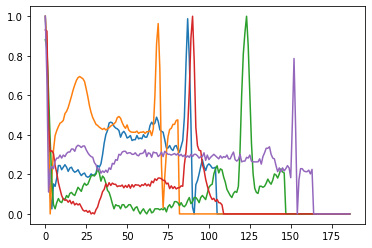

In [45]:
plt.plot(X[np.random.randint(0,100,5)].transpose())

In [41]:
X[np.random.randint(0,100,5)].shape

(5, 187)